In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split

In [2]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# path='/content/drive/My Drive/praca_mgr'
# os.chdir(path)

### Loading data

In [3]:
# data = pd.read_csv('./data/conditional_data_subset.csv', index_col=0)

data = pd.read_csv('../../conditional_data_subset.csv', index_col=0)
data = data.sample(frac=1).reset_index(drop=True)
data.shape

(962595, 11)

In [4]:
data['nonzero']=1
data.loc[data[data["nonzero"]==1]['PhotonSum']==0,'nonzero']=0
data = data.drop(columns=["PhotonSum"])
data.head()

Pdg       Energy            Vx            Vy        Vz        Px        Py  \
0  211     1.083050  0.000000e+00  0.000000e+00  0.000000  0.245958 -0.130974   
1  211     0.957797  0.000000e+00  0.000000e+00  0.000000 -0.444205 -0.199759   
2 -321     8.626920  0.000000e+00  0.000000e+00  0.000000  1.431040 -3.251070   
3   22     0.264403  3.290240e-07  9.945160e-07 -0.000005  0.061819  0.016184   
4 -211  2145.990000  0.000000e+00  0.000000e+00  0.000000  1.456610 -1.429340   

            Pz       mass  charge  nonzero  
0     1.037240  139.57061     1.0        0  
1     0.812819  139.57061     1.0        0  
2     7.846190  493.67700    -1.0        0  
3    -0.256564    0.00000     0.0        0  
4 -2145.990000  139.57061    -1.0        0

### Visualisation of features that allow for a good separation of classes

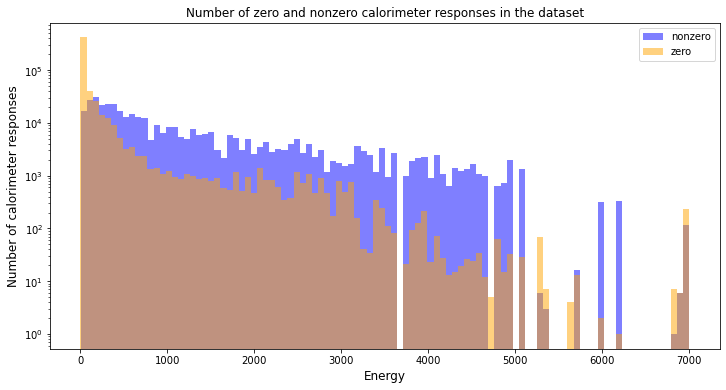

In [5]:
plt.figure(figsize=(12, 6))
plt.title("Number of zero and nonzero calorimeter responses in the dataset")
plt.hist(data['Energy'][data['nonzero']==1],bins=100, alpha=0.5, color="blue")
plt.hist(data['Energy'][data['nonzero']==0],bins=100, alpha=0.5, color="orange")
plt.legend(["nonzero","zero"])
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Number of calorimeter responses', fontsize=12)
plt.yscale("log")
plt.show()

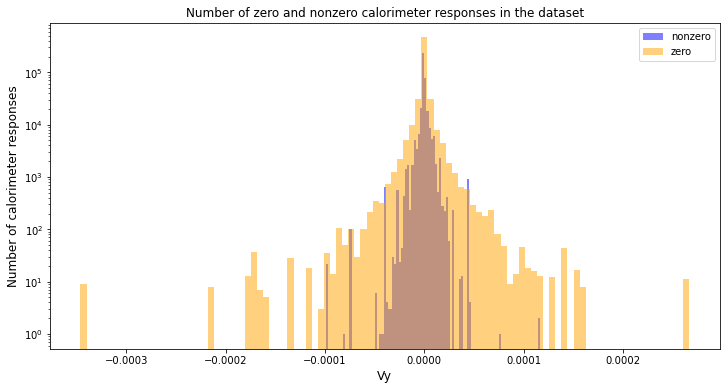

In [6]:
plt.figure(figsize=(12, 6))
plt.title("Number of zero and nonzero calorimeter responses in the dataset")
plt.hist(data['Vy'][data['nonzero']==1],bins=100, alpha=0.5, color="blue")
plt.hist(data['Vy'][data['nonzero']==0],bins=100, alpha=0.5, color="orange")
plt.legend(["nonzero","zero"])
plt.xlabel('Vy', fontsize=12)
plt.ylabel('Number of calorimeter responses', fontsize=12)
plt.yscale("log")
plt.show()

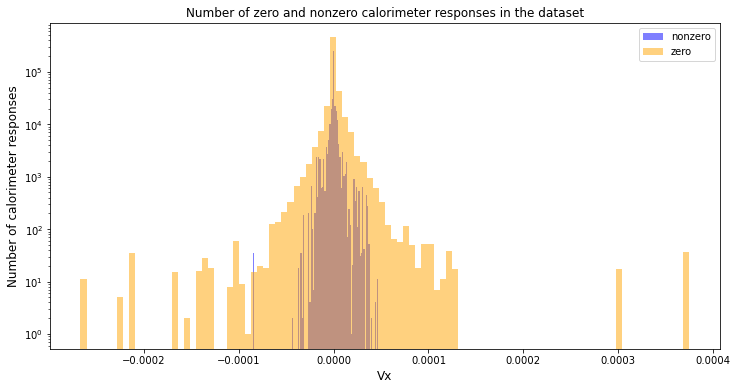

In [7]:
plt.figure(figsize=(12, 6))
plt.title("Number of zero and nonzero calorimeter responses in the dataset")
plt.hist(data['Vx'][data['nonzero']==1],bins=100, alpha=0.5, color="blue")
plt.hist(data['Vx'][data['nonzero']==0],bins=100, alpha=0.5, color="orange")
plt.legend(["nonzero","zero"])
plt.xlabel('Vx', fontsize=12)
plt.ylabel('Number of calorimeter responses', fontsize=12)
plt.yscale("log")
plt.show()

### Defining, training and evaluating the model

In [8]:
target = data['nonzero']

train = data.iloc[:int(data.shape[0]*0.75),:-1]
train_y = target.iloc[:int(data.shape[0]*0.75)]
test = data.iloc[int(data.shape[0]*0.75):,:-1]
test_y = target.iloc[int(data.shape[0]*0.75):]

sc = preprocessing.MinMaxScaler()
ttrain = sc.fit_transform(train)
ttest = sc.transform(test)

In [9]:
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
clf.fit(ttrain, train_y)
pred = clf.predict_proba(ttest)[:,1]
pred=(pred>0.5).astype('int')

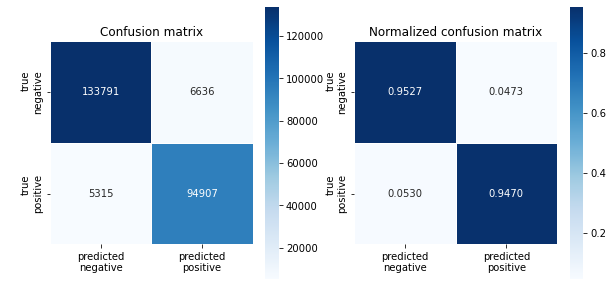

In [10]:
conf = confusion_matrix(test_y,pred)
plt.figure(figsize=(10,5))
plt.subplot(121)
x =  pd.DataFrame(conf)
x.columns = ["predicted\nnegative", "predicted\npositive"]
x[" "]=["true\nnegative", "true\npositive"]
x = x.set_index(' ')
plt.title('Confusion matrix')
sns.heatmap(x, annot=True, fmt="d", cmap="Blues", linewidths=.5, square = True)
plt.subplot(122)
conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
x =  pd.DataFrame(conf)
x.columns = ["predicted\nnegative", "predicted\npositive"]
x[" "]=["true\nnegative", "true\npositive"]
x = x.set_index(' ')
plt.title('Normalized confusion matrix')
sns.heatmap(x, annot=True, fmt=".4f", cmap="Blues", linewidths=.5, square = True)
plt.show()

In [11]:
import sklearn
print(sklearn.metrics.classification_report(test_y,pred, target_names=["zero", "nonzero"]))

              precision    recall  f1-score   support

        zero       0.96      0.95      0.96    140427
     nonzero       0.93      0.95      0.94    100222

    accuracy                           0.95    240649
   macro avg       0.95      0.95      0.95    240649
weighted avg       0.95      0.95      0.95    240649



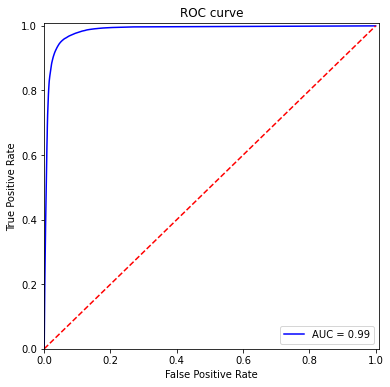

In [12]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(test_y, clf.predict_proba(ttest)[:,1])
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6, 6))
# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()